<h3> Luis Garduno <h3>

Dataset: [__International Database (IDB)__](https://www.census.gov/data-tools/demo/idb/#/country?COUNTRY_YEAR=2022&COUNTRY_YR_ANIM=2022)

Question Of Interest: Predict the population of earth in 2122.

# Data Understanding

## Data Description

In [1]:
import numpy as np
import pandas as pd

# Load dataset into dataframe
df = pd.read_csv('https://raw.githubusercontent.com/luisegarduno/MachineLearning_Projects/master/data/idb5yr.all', delimiter='|', encoding='ISO-8859-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34237 entries, 0 to 34236
Data columns (total 99 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   #YR        34237 non-null  int64  
 1   TFR        26163 non-null  float64
 2   SRB        26163 non-null  float64
 3   RNI        26172 non-null  float64
 4   POP95_99   26171 non-null  float64
 5   POP90_94   26171 non-null  float64
 6   POP85_89   26171 non-null  float64
 7   POP80_84   26171 non-null  float64
 8   POP75_79   26171 non-null  float64
 9   POP70_74   26171 non-null  float64
 10  POP65_69   26171 non-null  float64
 11  POP60_64   26171 non-null  float64
 12  POP5_9     26171 non-null  float64
 13  POP55_59   26171 non-null  float64
 14  POP50_54   26171 non-null  float64
 15  POP45_49   26171 non-null  float64
 16  POP40_44   26171 non-null  float64
 17  POP35_39   26171 non-null  float64
 18  POP30_34   26171 non-null  float64
 19  POP25_29   26171 non-null  float64
 20  POP20_

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Make year column easier to understand
df.rename(columns={'#YR':'YEAR'}, inplace=True)

# Remove every column except for year & population
for col in df.columns.values:
    if col != 'YEAR' and col != 'POP':
        df.drop(col, axis=1, inplace=True)

df.describe()

,YEAR,POP
count,34237.000000,3.423700e+04
mean,2024.935158,3.306017e+07
std,43.571971,1.253471e+08
min,1950.000000,2.028000e+03
25%,1987.000000,4.304230e+05
50%,2025.000000,4.831844e+06
75%,2063.000000,2.070922e+07
max,2100.000000,1.647894e+09



------------------------

## Data Quality

Number of unique values in column "YEAR" :  151


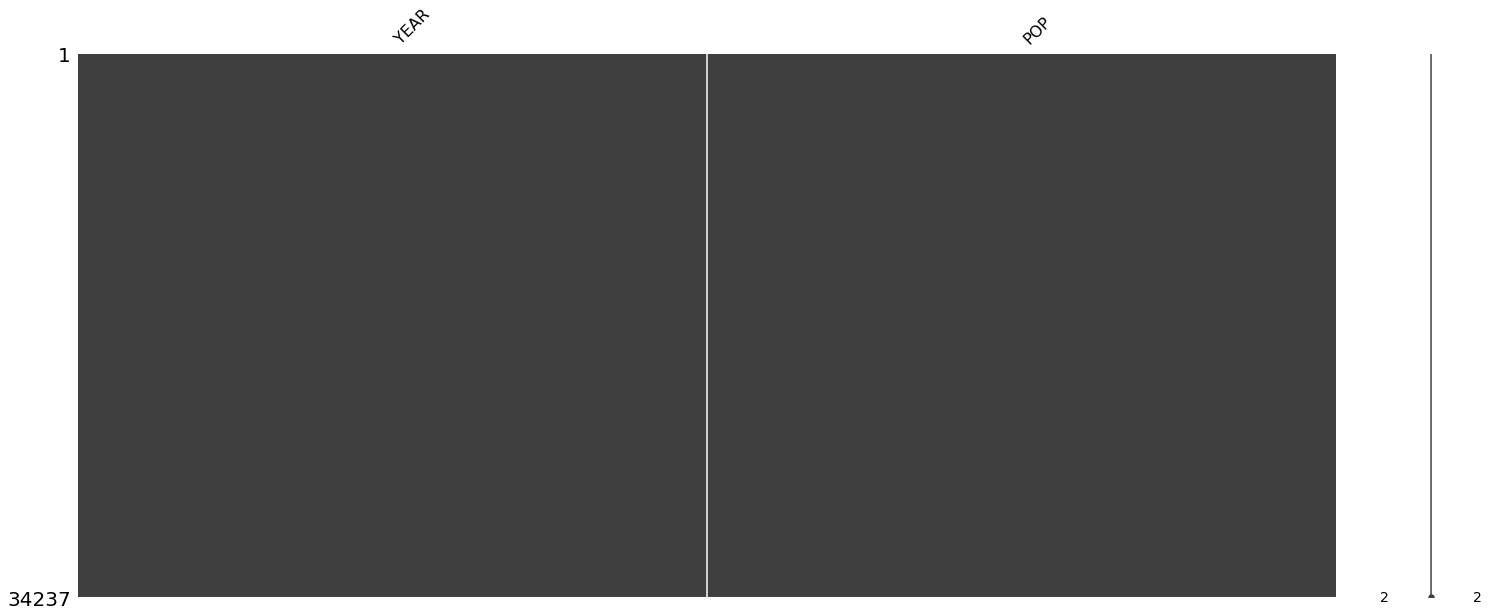

In [3]:
import missingno as mn

mn.matrix(df)

# Count unique values in column 'gameId' of the dataframe
print('Number of unique values in column "YEAR" : ', df['YEAR'].nunique())


------------------------

## Cleaning the Dataset

In [4]:
# Group by year & get sum
df_yr = df.groupby(by='YEAR')
df_yr = df_yr['POP'].sum()

# Create a new dataframe with new data (1961 - 2100)
pop_sum = []
for i in range(1950, 2100):
    pop_sum.append(df_yr[i])
df_pop = pd.DataFrame({'YEAR': list(range(1950, 2100)), 'POP': pop_sum})
df = df_pop

print(f'\n--> Current Population (2021): {df["POP"][60]:,d}\n')
df.tail(5)


--> Current Population (2021): 6,939,761,510



,YEAR,POP
145,2095,10607139375
146,2096,10611426065
147,2097,10614549747
148,2098,10616473648
149,2099,10617184877


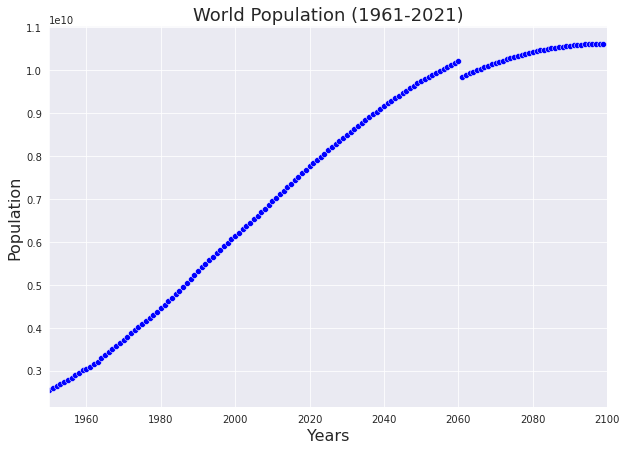

In [5]:
sns.set_style("darkgrid")
plt.subplots(figsize=(10,7))
ax = sns.scatterplot(data=df, x='YEAR', y='POP', color='blue')
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Population', fontsize=16)
ax.set_title('World Population (1961-2021)', fontsize=18)
plt.xlim(1950, 2100)

plt.show()

In [6]:
# Define X & Y
if 'POP' in df_pop:
    y = df_pop['POP'].values
    del df_pop['POP']
    X = df_pop.to_numpy()


----------------------


# Modeling

Derived the formula for calculating the optimal values of the regression weights:

$$ w = (X^TX)^{-1}X^Ty $$

where $X$ is the matrix of values with a bias column of ones appended onto it.
For the population dataset one could construct this $X$ matrix by stacking a column of ones onto the `df_pop.YEAR` matrix. 

$$ X=\begin{bmatrix}
         & \vdots &        &  1 \\
        \dotsb & \text{ds.data} & \dotsb &  \vdots\\
         & \vdots &         &  1\\
     \end{bmatrix}
$$

In [7]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Create a matrix full of ones & stack 2 matrices horizontally
qs = X.reshape((len(X),))
cs = CubicSpline(qs, y)
xs = np.arange(1950, 2122, 1)
X_x = cs(xs)
X = np.hstack((np.ones((len(X), 1)), X))

# Calculate optimal values of the regression weights
w = np.linalg.inv(X.T @ X) @ X.T @ y

print("\n++++++++++++++ WEIGHTS +++++++++++++++++\n", pd.DataFrame(data=w))
diff = np.round(( (y - (abs(np.dot(X,w) - y))) / y ) * 100, 2)
print("\n============= TARGET PERCENT ACCURACY ===============\n", pd.DataFrame(data=diff))


++++++++++++++ WEIGHTS +++++++++++++++++
               0
0 -1.153815e+11
1  6.068489e+07

============= TARGET PERCENT ACCURACY ===============
          0
0    84.50
1    83.82
2    83.36
3    83.07
4    82.91
..     ...
145  89.19
146  88.67
147  88.13
148  87.58
149  87.01

[150 rows x 1 columns]



---------------------------

To predict the output from our model, $\hat{y}$,from $w$ and $X$ we need to use

$\hat{y}=w^TX^T$, for row vector $\hat{y}$

In [8]:
yHat_np = w.T @ X.T        # Shape : (1,61)
yHat_np = yHat_np.ravel()  # Shape : (61,)

MSE_np = (np.square(y - yHat_np)).mean()
print(f'MSE: {round(MSE_np):,d}')

MSE: 308,045,246,691,123,328



Linear Regression	   --> ~Population (2122): 13,391,873,158

Cubic Spline Interpolation --> ~Population (2122): 10,309,673,915



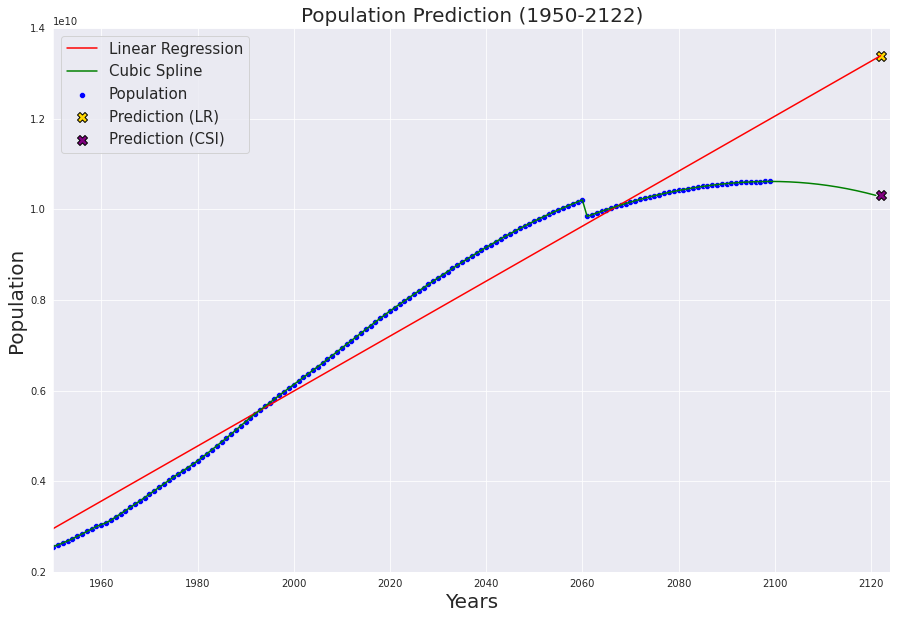

In [24]:
X_new = np.array([[0], [2122]])
X_test = np.c_[np.ones((len(X_new), 1)), X_new]
y_test = X_test.dot(w)
print(f'\nLinear Regression\t   --> ~Population (2122): {round(y_test[1]):,d}\n')
print(f'Cubic Spline Interpolation --> ~Population (2122): {round(X_x[len(X_x) - 1]):,d}\n')

sns.set_style("darkgrid")
plt.subplots(figsize=(15,10))

plt.plot(X_new, y_test, "r-", color='red')
plt.plot(xs, cs(xs), 'r-', color='green')
sns.scatterplot(data=df, x='YEAR', y=y, color='blue')
sns.scatterplot(x=X_new[1], y=y_test[1], s=100, marker="X", linewidth=1, edgecolor='k', color='gold')
sns.scatterplot(x=[2122], y=X_x[len(X_x) - 1], s=100, marker="X", linewidth=1, edgecolor='k', color='purple')

plt.xlabel('Years', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Population Prediction (1950-2122)', fontsize=20)
plt.axis([1950, 2124, 2000000000, 14000000000])
plt.legend(["Linear Regression", "Cubic Spline", "Population", "Prediction (LR)", "Prediction (CSI)"], prop={'size': 15})
plt.show()

-----------------------------

# Comparing Performance

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
MSE_sk = mean_squared_error(y, reg.predict(X))
y_testsk = reg.predict(X_test)

print("******** Linear Equation ********")
print("[Numpy] \th =", round(w[0],3), "* x + (" + str(round(w[1],5)) + ")")
print("[Sklearn]\th =", round(reg.intercept_,3), "* x + (" + str(round(reg.coef_[1],5)) + ")\n")

print("******** Mean Squared Error ********")
print(f'[Numpy] \tMSE: {round(MSE_np):,d}')
print(f'[Sklearn]\tMSE: {round(MSE_sk):,d}\n')

print("******** Population Prediction - 2122 ********")
print(f'[Numpy] \t {round(y_test[1]):,d}')
print(f'[Sklearn]\t {round(y_testsk[1]):,d}\n')

******** Linear Equation ********
[Numpy] 	h = -115381468875.745 * x + (60684892.57002)
[Sklearn]	h = -115381468875.739 * x + (60684892.57002)

******** Mean Squared Error ********
[Numpy] 	MSE: 308,045,246,691,123,328
[Sklearn]	MSE: 308,045,246,691,124,480

******** Population Prediction - 2122 ********
[Numpy] 	 13,391,873,158
[Sklearn]	 13,391,873,158




---------------------

#### References

Census. International Database (IDB). https://www.census.gov/data-tools/demo/idb/#/country?COUNTRY_YEAR=2022&COUNTRY_YR_ANIM=2022 (Accessed 01-22-2022)

Variable definitions. International Database (IDB). https://www.census.gov/data/developers/data-sets/international-database.html (Accessed 01-22-2022)

Release notes. International Database (IDB). https://www.census.gov/programs-surveys/international-programs/about/idb.html (Accessed 01-22-2022)

Methodology. International Database (IDB). https://www2.census.gov/programs-surveys/international-programs/technical-documentation/methodology/idb-methodology.pdf (Accessed 01-22-2022)

Census Data API Variables. International Database (IDB). https://api.census.gov/data/timeseries/idb/5year/variables.html (Accessed 01-22-2022)
